# Endogenous grid method

Consider the following problem
$$ v(a,s) = \max_{c,a'} u(c) + \beta E\left[ v(a',s') \mid a,s \right]$$
$$ \text{ s.t.} \,\,\, c+a'=(1+r)a+ws  \text{ and}\,\, a'> -\phi$$


##  Asset grid 
Since borrowing constraint is $-\phi$, we can view borrowing constraint as $0$ by adding $\phi$ to both sides.

Let $a2 = a'+\phi, a1 = a+\phi$,  
  
  
## Wealth grid
 Let $x$ be wealth (cash at hand).
We also want to deal with borrowing constraint in the wealth.  
  

   \textbf{NOTICE!!} 
  If we set $x =(1+r)a +ws$, lower bound of wealth is 0. it is not appropriate in this problem.

 Lower bound of wealth is $-\phi$.

 When $c=0$, $a'=-\phi$, lower bound of wealth is $-\phi$.
 Thus we consider wealth as $x= (1+r)a+ws + \phi$ to deal with borrowing constraint.
 

 Wealth can be written as  $x=(1+r) a1+s -r\phi$.

## Transformed Bellman equation
Then the Bellman equation is transformed as
$$v(x,s) = \max_{c,a'} u(c) + \beta E\left[v(x',s) \mid a,s\right]$$

$$ \text{ s.t.}\,\,\, c + a2 = x \text{ and} \,\,\,\, a2>0$$

We solve this problem for policy function for asset ($a2$).

In [1]:
using Interpolations
using BenchmarkTools
using Plots
gr()

Plots.GRBackend()

In [2]:
include("mylininterp.jl")

mylininterp (generic function with 1 method)

In [3]:
function EGM()
    
    """
    This function is written by Tokuma Suzuki.
    My code is based on Quantitative Macroeconomics lecture at University of Tokyo taught by Makoto Nirei.
    
    """
    
    # primitive parameters
    const β=0.96 # subjective discount factor 
    const σ =3.0 # relative risk aversion
    const ϕ=0.5  # borrowing limit (positive value)
    
    # utility function
    u(c::Float64) = (c^(1.0-σ))/(1.0-σ)
    u′(c::Float64) = c^(-σ)
    u′_inv(val::Float64) = val^(-1.0/σ)
    
    # create shock grid
    zgrid = [0.2  1.0] # productivity shock
    Π =[0.7 0.3; 0.1 0.9] # transition matrix
    const nz = size(zgrid,2)
    
    # factor price
    const r = 0.03 
    const w = 1.0 
    
    # create asset grid  a2 = a' + phi
    const a2min = 1e-5 
    const a2max = 10.0
    const na = 100
    a2grid = logspace(log10(a2min),log10(a2max),na) 
    
    # for convenience
    a2mat = repmat(a2grid,1,2)  
    zmat = repmat(zgrid ,na)

    # initialize asset matrices 
    amat = zeros(na,nz)  # asset grid (we compute  it later) range [a2min-ϕ, a2max-ϕ]
    a1= zeros(na,nz) # today's asset + ϕ
    wealth = zeros(na,nz) # wealth matrix
    wealth = (1.0+r)*a2mat + w*zmat -r*ϕ

    # initialize consumption matrices
    c1 = zeros(na,nz) # consumption matrix in this period
    c2 = zeros(na,nz)  # consumption matrix in the next period
    EMU = zeros(na,nz) # expected marginal utility matrix in the next period
    
    # initialize policy functions 
    pol_c =zeros(na,nz) # policy function for consumption
    pol_a = zeros(na,nz) # policy function for asset
    pol_a = 0.5 * a2mat # initial guess of policy function 
    new_pol_a =zeros(na,nz) # updated policy
    
    # iteration settings
    const small = 1e-13
    const tol = 1e-13
    const maxiter = 10000
    
    # main loop 
    for it in 1:maxiter
        
        c2 = wealth - pol_a 
        @views c2[c2.<0.0] = small # replace negative consumption with very small number
         EMU = u′.(c2)*Π' 
        @. c1 = u′_inv(β*(1.0+r)*EMU)
        
        # budget constraint: c + a' = (1+r)a + w*z 
        # rearranging this as
        # c + a' +ϕ = (1+r)(a+ϕ) +w*z -r*ϕ
        
        a1 .=((c1+a2mat) - w*zmat + ϕ*r)./(1.0+r) # compute asset matrix
        
        # compute updated policy function
        @inbounds for i in 1:nz
            @views new_pol_a[:,i]  = mylininterp((1.0+r)*a1[:,i]+ w*zgrid[i] -r*ϕ, a2grid,wealth[:,i] )
        end
        
        @views new_pol_a[new_pol_a.<a2min] = a2min # replace extrapolation with lower bound.
        err = maximum(abs.(new_pol_a-pol_a))
        pol_a =copy(new_pol_a)

        if err < tol
            # compute asset grid 
            #  wealth = (1.0+r).*a2mat + w.*zmat -r*ϕ
            @views @. amat = (wealth - w*zmat -ϕ)/(1.0+r)
            pol_c = wealth- new_pol_a 
            break
        end
        
    end
   
    return amat[:,1], new_pol_a, pol_c
end

EGM (generic function with 1 method)

In [4]:
agrid, pol_a, pol_c = EGM()

([-0.49999, -0.499989, -0.499987, -0.499985, -0.499983, -0.49998, -0.499977, -0.499973, -0.499969, -0.499965  …  2.34804, 2.77455, 3.26494, 3.82876, 4.47702, 5.22237, 6.07933, 7.06463, 8.19749, 9.5], [1.0e-5 0.454354; 1.0e-5 0.454355; … ; 8.12617 8.83781; 9.40792 10.1231], [0.185 0.530657; 0.185002 0.530657; … ; 1.01724 1.1056; 1.07708 1.16192])

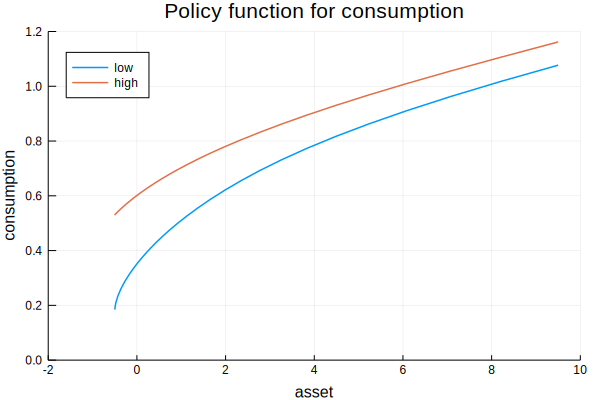

In [5]:
labels = ["low" "high"]
plot(agrid,pol_c, linewidth = 1.5,label=labels,legend=:topleft, ylims=(0,1.2), yticks=0:0.2:1.2,xlims=(-2,10)) 
title!("Policy function for consumption ")

xaxis!("asset")
yaxis!("consumption")

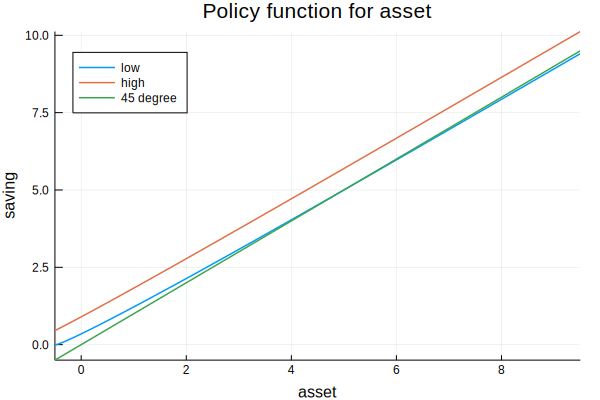

In [6]:
plot(agrid,pol_a,linewidth = 1.5, label = labels,legend=:topleft)
plot!(agrid,agrid,linewidth = 1.5 ,label = "45 degree",legend=:topleft)
title!("Policy function for asset ")
xaxis!("asset")
yaxis!("saving")

In [7]:
@benchmark EGM()

BenchmarkTools.Trial: 
  memory estimate:  18.42 MiB
  allocs estimate:  30257
  --------------
  minimum time:     42.622 ms (0.00% GC)
  median time:      46.542 ms (3.88% GC)
  mean time:        47.018 ms (3.26% GC)
  maximum time:     57.517 ms (0.00% GC)
  --------------
  samples:          107
  evals/sample:     1